# Load Data

In [ ]:
import pandas as pd
import numpy as np

# Definisikan path file
path = '/content/drive/MyDrive/Colab Notebooks/RisetHibahPemerintah/Eksperimen - Klasifikasi Teks/'

data = pd.read_csv(path + 'datamodel_klasifikasi_clean.csv')
df = data[['Answer_fix', 'topik']].copy()

In [ ]:
df.head()

,Answer_fix,topik
0,"['insomnia', 'sakit', 'gejala', 'sakit', 'saki...",depresi
1,"['asa', 'debar', 'debar', 'irama', 'jantung', ...",stres
2,"['paham', 'asa', 'anak', 'tua', 'cerai', 'muda...",depresi
3,"['maria', 'prihatin', 'kondisi', 'alami', 'pen...",depresi
4,"['depresi', 'bentuk', 'mental', 'perhati', 'ma...",depresi


In [ ]:
df['Answer_fix'] = df['Answer_fix'].apply(eval)  # Konversi string list ke list

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Ekstraksi fitur menggunakan N-Gram pada data yang sudah ditokenisasi
ngram_vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer=lambda x: x, lowercase=False, max_features=100)
X_ngram = ngram_vectorizer.fit_transform(df['Answer_fix'])

# Setting data
nama_ekstraksi = 'X_ngram'
fitur = X_ngram
y = df['topik']

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Mengecek jumlah nilai unik (jumlah fitur) dalam X_ngram
jumlah_fitur = X_ngram.shape[1]

print(f"Jumlah nilai unik (fitur) dalam X_ngram: {jumlah_fitur}")

Jumlah nilai unik (fitur) dalam X_ngram: 100


# import modul

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
import json
import nltk

# Pastikan nltk sudah terinstall
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from sklearn.model_selection import cross_val_predict

In [ ]:
!pip install sklearn-genetic-opt

In [ ]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous

In [ ]:
import joblib
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn_genetic")

# Ganti backend joblib
joblib.parallel_backend('threading')

# Setel variabel lingkungan untuk joblib
os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp'
os.environ['JOBLIB_PARALLEL_BACKEND'] = 'threading'

# BC SplitV modelling

In [ ]:
# Define models
models = {
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'KNN': KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='auto', p=2),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5, min_samples_leaf=2, bootstrap=True),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', learning_rate='adaptive', max_iter=1000, early_stopping=True, n_iter_no_change=5)
}

# Bagging classifier
optimasi = 'BC optimization'
def get_bagging_clf(base_estimator):
    return BaggingClassifier(estimator=base_estimator, n_estimators=10, random_state=42, n_jobs=-1)

In [ ]:
# Define split ratios
splits = [(0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]

# Initialize results dictionary
results = {}

for train_size, test_size in splits:
    print(f'Processing split {int(train_size*100)}:{int(test_size*100)}')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(fitur, y, test_size=test_size, random_state=42)

    for model_name, model in models.items():
        print(f'  Training {model_name} with Bagging Classifier')

        # Create Bagging Classifier with the current model
        bagging_clf = get_bagging_clf(model)
        bagging_clf.fit(X_train, y_train)
        y_pred = bagging_clf.predict(X_test)

        # Evaluation
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)

        # Convert tuple key to string
        result_key = f"{model_name}_{optimasi}_split {int(train_size*100)}:{int(test_size*100)}"

        # Save results
        results[result_key] = {
            'confusion_matrix': conf_matrix.tolist(),
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Classification Report:')
        print(classification_report(y_test, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_bc_sv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Processing split 60:40


NameError: name 'fitur' is not defined

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_bc_sv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_BC optimization_split')
    split_ratio = split_info.replace('_test', ':')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['Split', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='Split', columns='Model', values='Accuracy')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Naive Bayes', 'KNN', 'Random Forest', 'Neural Network']]

# Tampilkan tabel akurasi
accuracy_table

In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

# BC CrossV modelling

In [ ]:
# Define models
models = {
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'KNN': KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='auto', p=2),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5, min_samples_leaf=2, bootstrap=True),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', learning_rate='adaptive', max_iter=1000, early_stopping=True, n_iter_no_change=5)
}

# Bagging classifier function
optimasi = 'BC optimization'
def get_bagging_clf(base_estimator):
    return BaggingClassifier(estimator=base_estimator, n_estimators=10, random_state=42, n_jobs=-1)

In [ ]:
# Define cross-validation folds
kf_values = [5, 10]

# Initialize results dictionary
results = {}

for k in kf_values:
    print(f'Processing cross-validation with k={k}')

    for model_name, model in models.items():
        print(f'  Training {model_name} with Bagging Classifier')

        # Create Bagging Classifier with the current model
        bagging_clf = get_bagging_clf(model)

        # Cross-validation predictions
        y_pred = cross_val_predict(bagging_clf, fitur, y, cv=k)

        # Evaluation
        conf_matrix = confusion_matrix(y, y_pred)
        class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y, y_pred)

        # Convert key to string, similar to the split validation
        result_key = f"{model_name}_{optimasi}_cross_val_k{k}"

        # Save results in the format similar to split validation
        results[result_key] = {
            'confusion_matrix': conf_matrix.tolist(),  # Convert array to list
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Classification Report:')
        print(classification_report(y, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_bc_cv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Processing cross-validation with k=5
  Training Naive Bayes with Bagging Classifier
    Accuracy: 0.7647
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.76      0.69      0.72       956
     depresi       0.74      0.85      0.79      1456
       stres       0.80      0.72      0.76      1323

    accuracy                           0.76      3735
   macro avg       0.77      0.75      0.76      3735
weighted avg       0.77      0.76      0.76      3735

  Training KNN with Bagging Classifier
    Accuracy: 0.7390
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.72      0.63      0.67       956
     depresi       0.73      0.80      0.77      1456
       stres       0.75      0.75      0.75      1323

    accuracy                           0.74      3735
   macro avg       0.74      0.73      0.73      3735
weighted avg       0.74      0.74      0.74      3735

  Training Random F

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_bc_cv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

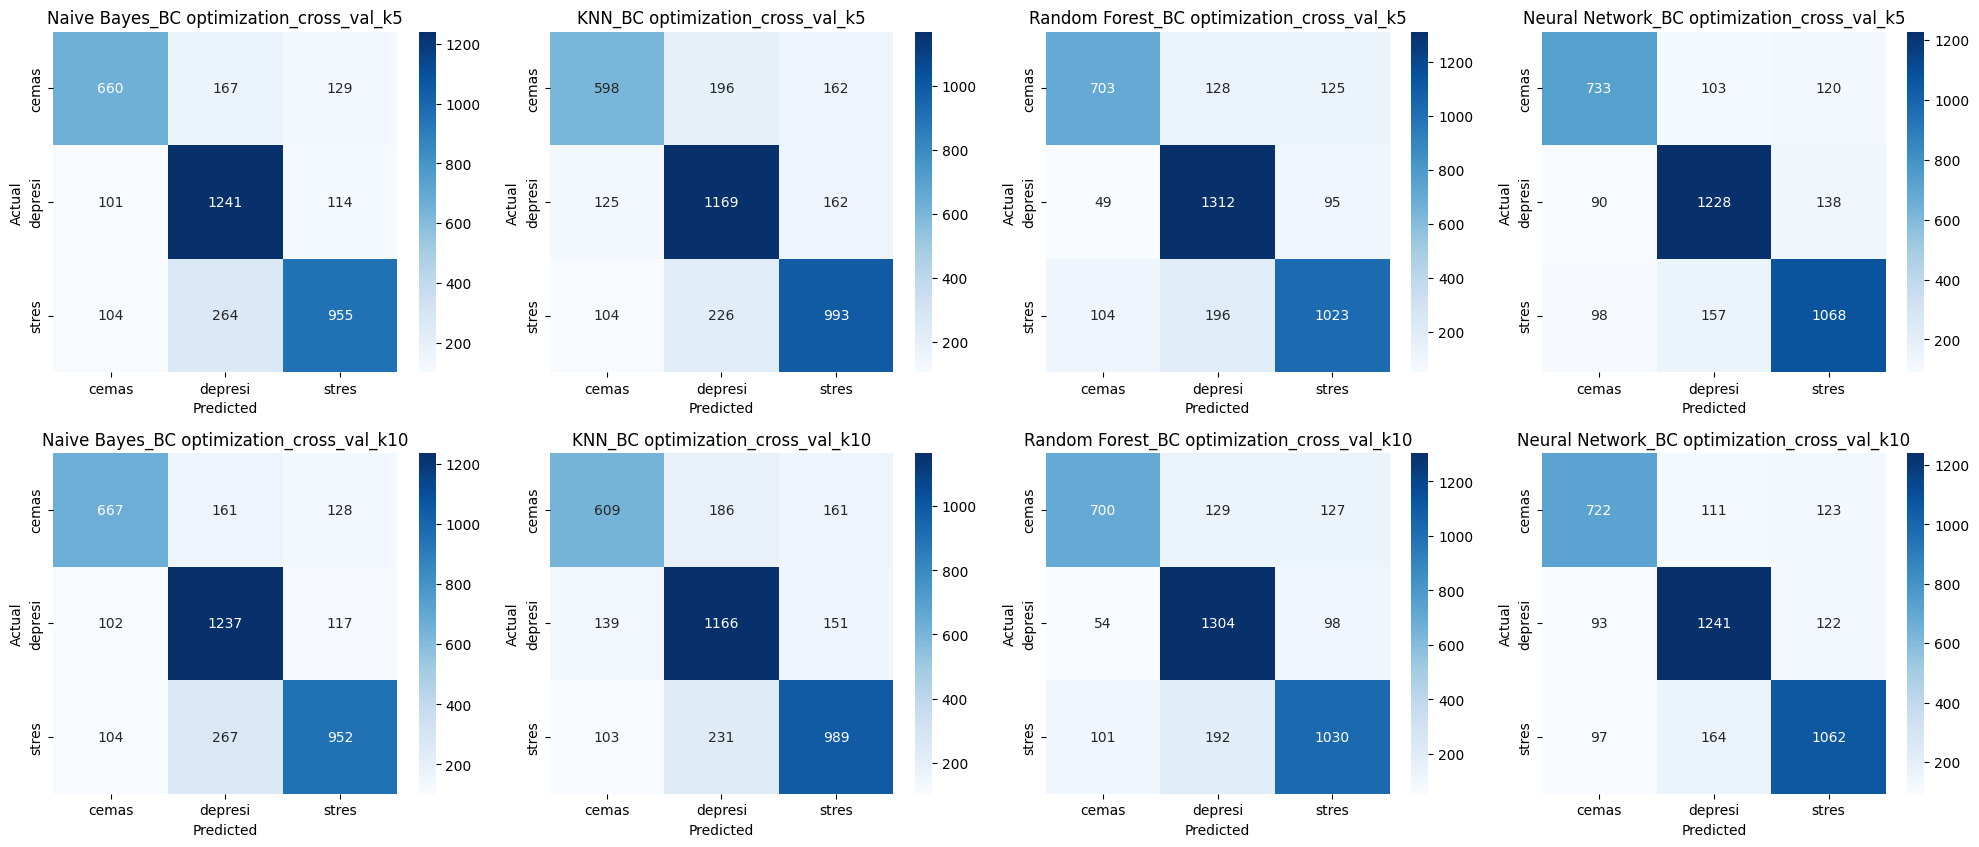

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    # if i >= 20:  # Limit to 20 subplots (5 rows x 4 columns)
    #     break
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_k')
    split_ratio = split_info.replace('cross_val_', '')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['K-Fold', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='K-Fold', columns='Model', values='Accuracy')

# Rename columns to remove the extra text
accuracy_table.columns = accuracy_table.columns.str.replace('_BC optimization_cross_val', '')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Naive Bayes', 'KNN', 'Random Forest', 'Neural Network']]

# Tampilkan tabel akurasi
accuracy_table

Model,Naive Bayes,KNN,Random Forest,Neural Network
K-Fold,,,,
10,0.764659,0.740027,0.812316,0.809906
5,0.764659,0.738956,0.813387,0.810977


In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

,Experiment,Label,Precision,Recall,F1-Score,Support
0,Naive Bayes_BC optimization_cross_val_k5,cemas,0.763006,0.690377,0.724876,956.0
1,Naive Bayes_BC optimization_cross_val_k5,depresi,0.742225,0.852335,0.793478,1456.0
2,Naive Bayes_BC optimization_cross_val_k5,stres,0.797162,0.721844,0.757636,1323.0
3,KNN_BC optimization_cross_val_k5,cemas,0.723096,0.625523,0.670780,956.0
4,KNN_BC optimization_cross_val_k5,depresi,0.734758,0.802885,0.767312,1456.0
5,KNN_BC optimization_cross_val_k5,stres,0.753986,0.750567,0.752273,1323.0
6,Random Forest_BC optimization_cross_val_k5,cemas,0.821262,0.735356,0.775938,956.0
7,Random Forest_BC optimization_cross_val_k5,depresi,0.801956,0.901099,0.848642,1456.0
8,Random Forest_BC optimization_cross_val_k5,stres,0.823009,0.773243,0.797350,1323.0
9,Neural Network_BC optimization_cross_val_k5,cemas,0.795874,0.766736,0.781034,956.0


# GA SplitV modelling

In [ ]:
models = {
    'Naive Bayes': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier()
}
optimasi = 'GA optimization'

In [ ]:
splits = [(0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]
results = {}

def get_ga_search(model):
    param_grids = {
        'MultinomialNB': {'alpha': Continuous(0.01, 0.1, distribution='log-uniform')},
        'KNeighborsClassifier': {'n_neighbors': Integer(10, 30), 'weights': Categorical(['distance']), 'p': Integer(1, 2)},
        'RandomForestClassifier': {'n_estimators': Integer(50, 100), 'max_depth': Integer(10, 20)},
        'MLPClassifier': {'hidden_layer_sizes': Categorical([(100,), (100, 50)]), 'learning_rate_init': Continuous(0.001, 0.005), 'learning_rate': Categorical(['adaptive']), 'early_stopping': Categorical([True])}
    }

    model_name = type(model).__name__
    if model_name not in param_grids:
        raise ValueError(f"Parameter grid for {model_name} not defined")

    ga_search = GASearchCV(
        estimator=model,
        param_grid=param_grids[type(model).__name__],
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
        verbose=True,
        population_size=20,
        generations=4
    )
    return ga_search

In [ ]:
for train_size, test_size in splits:
    print(f'Processing split {int(train_size*100)}:{int(test_size*100)}')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(fitur, y, test_size=test_size, random_state=42)

    for model_name, model in models.items():
        print(f'  Training {model_name} with GASearchCV')

        # Create GASearchCV with the current model
        ga_search = get_ga_search(model)
        ga_search.fit(X_train, y_train)
        y_pred = ga_search.predict(X_test)

        # Evaluation
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)

        # Convert tuple key to string
        result_key = f"{model_name}_{optimasi}_split {int(train_size*100)}:{int(test_size*100)}"

        # Save results
        results[result_key] = {
            'best_params': ga_search.best_params_,
            'confusion_matrix': conf_matrix.tolist(),
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Best Params:', ga_search.best_params_)
        print('    Classification Report:')
        print(classification_report(y_test, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_ga_sv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Processing split 60:40
  Training Naive Bayes with GASearchCV
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.763498	0          	0.763498   	0.763498   
1  	40    	0.763498	0          	0.763498   	0.763498   
2  	40    	0.763498	0          	0.763498   	0.763498   
3  	40    	0.763498	0          	0.763498   	0.763498   
4  	40    	0.763498	0          	0.763498   	0.763498   
    Accuracy: 0.7631
    Best Params: {'alpha': 0.03560870121770821}
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.75      0.70      0.72       397
     depresi       0.76      0.84      0.80       591
       stres       0.78      0.73      0.75       506

    accuracy                           0.76      1494
   macro avg       0.76      0.75      0.76      1494
weighted avg       0.76      0.76      0.76      1494

  Training KNN with GASearchCV
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.715462	0.0146845  	0.7344

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_ga_sv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

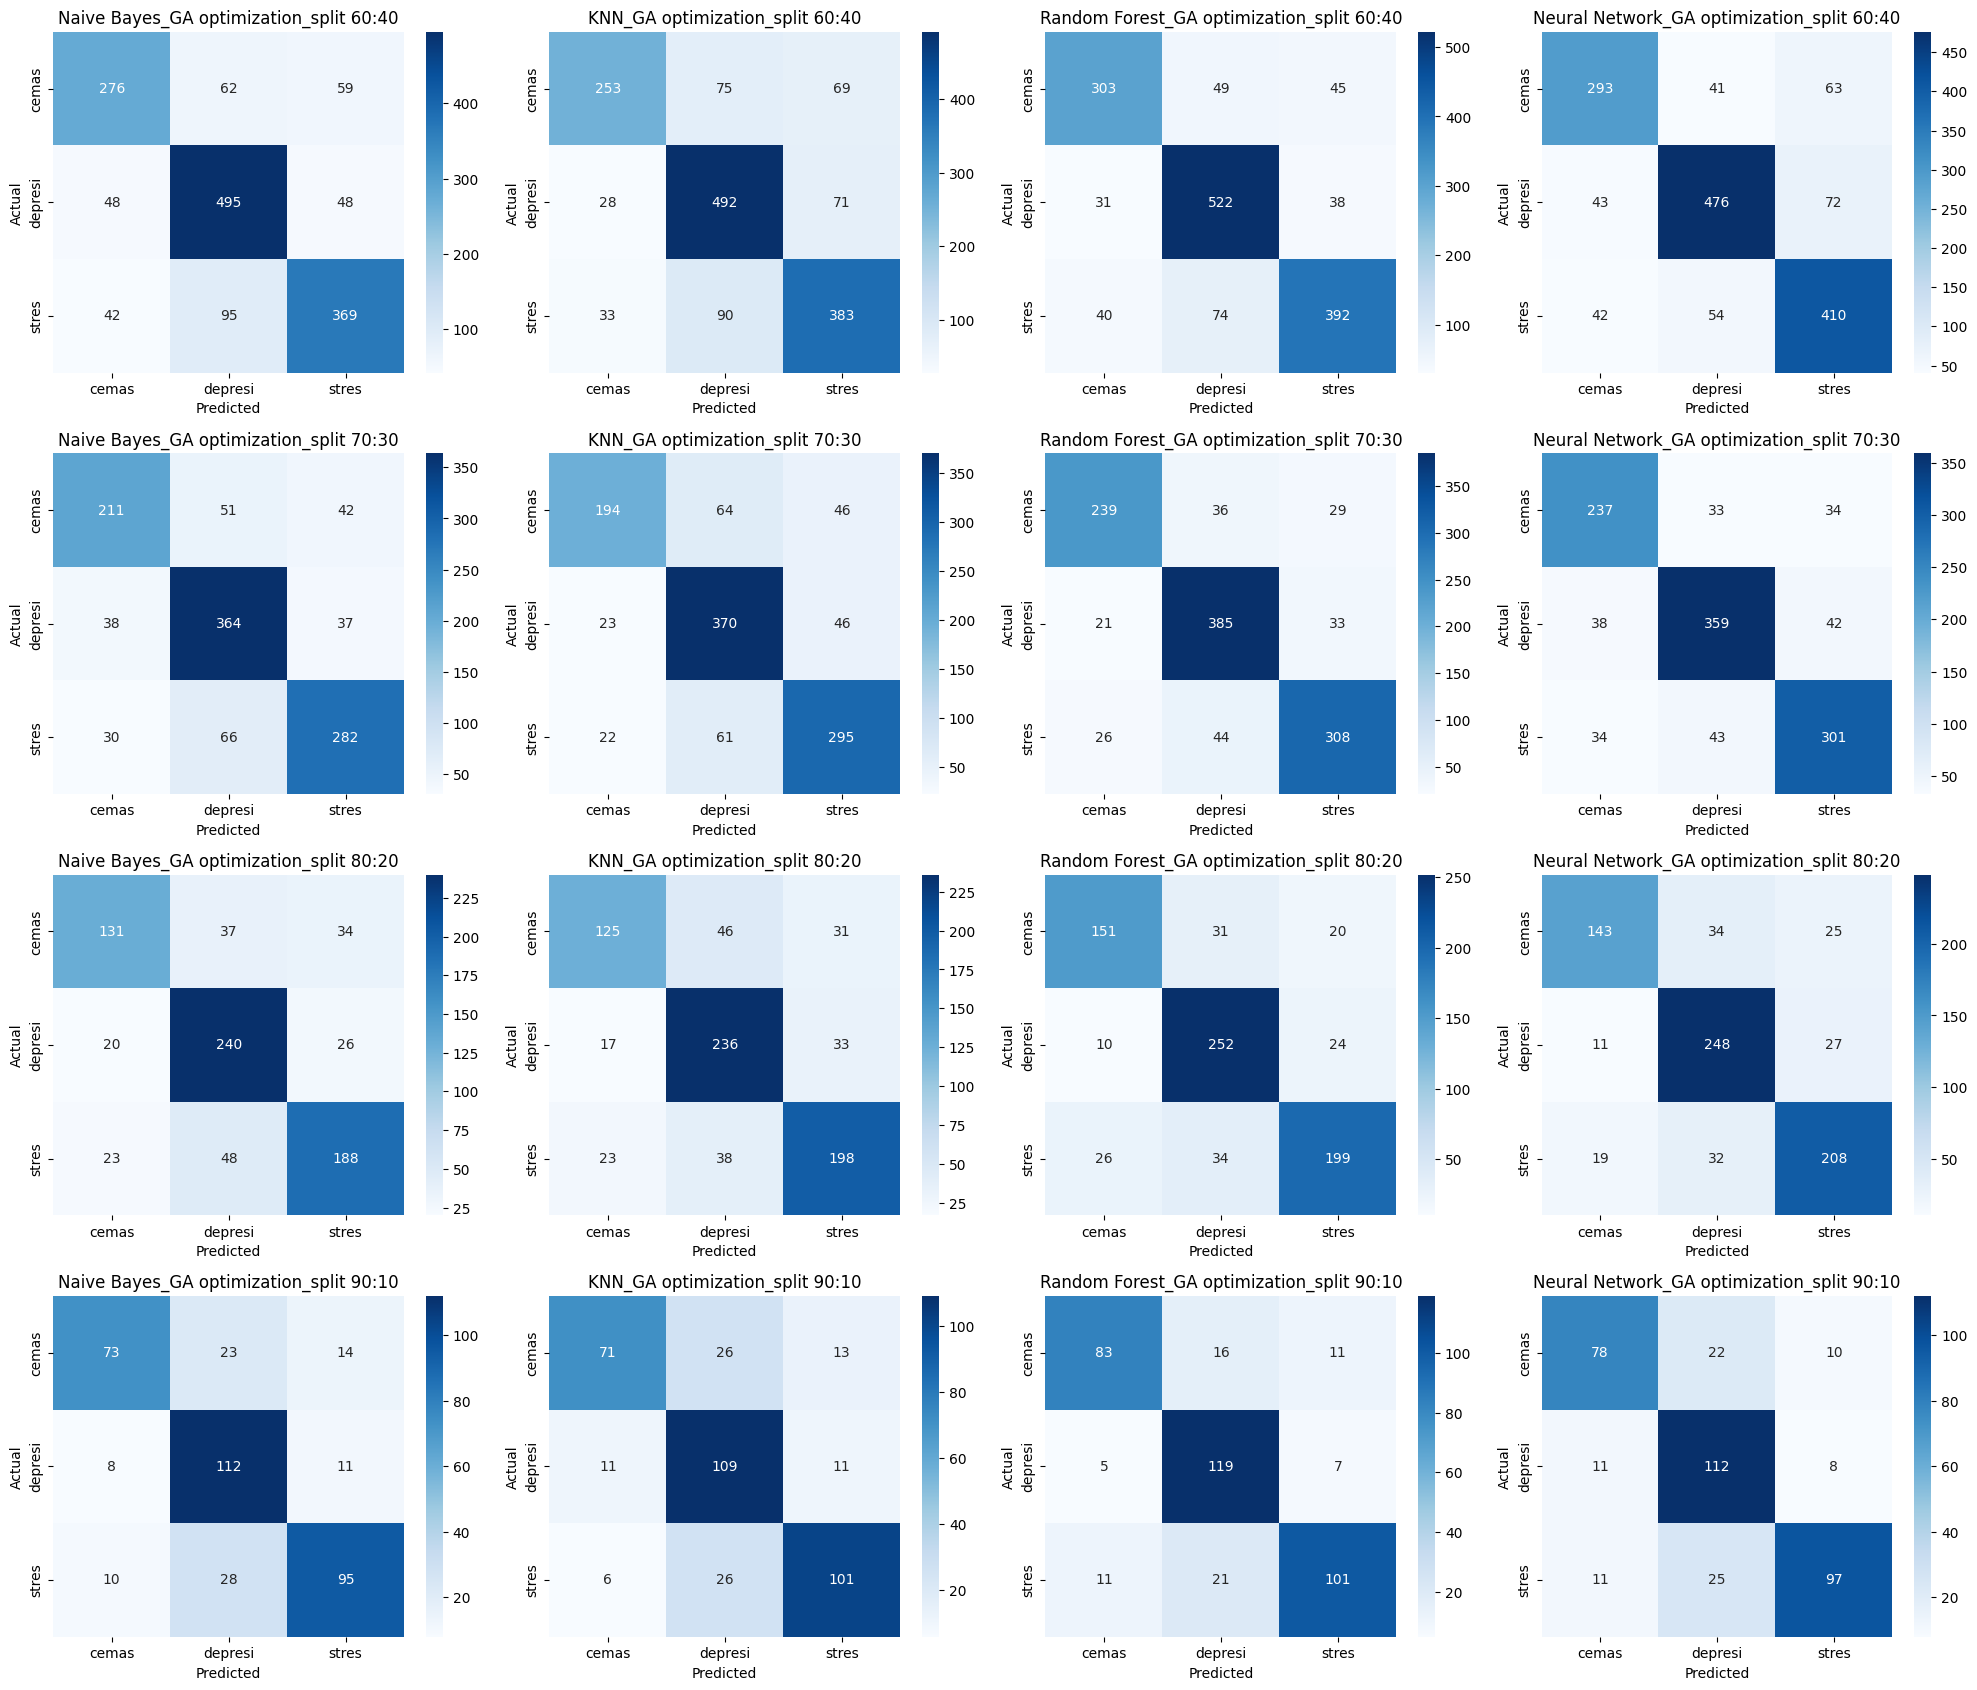

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_split ')
    split_ratio = split_info.replace('split ', '')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['Split', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='Split', columns='Model', values='Accuracy')

# Rename columns to remove the extra text
accuracy_table.columns = accuracy_table.columns.str.replace('_GA optimization', '')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Naive Bayes', 'KNN', 'Random Forest', 'Neural Network']]

# Tampilkan tabel akurasi
accuracy_table

Model,Naive Bayes,KNN,Random Forest,Neural Network
Split,,,,
60:40,0.763052,0.755020,0.814592,0.789157
70:30,0.764496,0.766280,0.831401,0.800178
80:20,0.748327,0.748327,0.805890,0.801874
90:10,0.748663,0.751337,0.810160,0.767380


In [ ]:
print(accuracy_table.columns)

Index(['Naive Bayes', 'KNN', 'Random Forest', 'Neural Network'], dtype='object', name='Model')


In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

,Experiment,Label,Precision,Recall,F1-Score,Support
0,Naive Bayes_GA optimization_split 60:40,cemas,0.754098,0.695214,0.723460,397.0
1,Naive Bayes_GA optimization_split 60:40,depresi,0.759202,0.837563,0.796460,591.0
2,Naive Bayes_GA optimization_split 60:40,stres,0.775210,0.729249,0.751527,506.0
3,KNN_GA optimization_split 60:40,cemas,0.805732,0.637280,0.711674,397.0
4,KNN_GA optimization_split 60:40,depresi,0.748858,0.832487,0.788462,591.0
5,KNN_GA optimization_split 60:40,stres,0.732314,0.756917,0.744412,506.0
6,Random Forest_GA optimization_split 60:40,cemas,0.810160,0.763224,0.785992,397.0
7,Random Forest_GA optimization_split 60:40,depresi,0.809302,0.883249,0.844660,591.0
8,Random Forest_GA optimization_split 60:40,stres,0.825263,0.774704,0.799185,506.0
9,Neural Network_GA optimization_split 60:40,cemas,0.775132,0.738035,0.756129,397.0


# GA CrossV modelling

In [ ]:
models = {
    'Naive Bayes': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier()
}
optimasi = 'GA optimization'

In [ ]:
def get_ga_search(model):
    param_grids = {
        'MultinomialNB': {'alpha': Continuous(0.01, 0.1, distribution='log-uniform')},
        'KNeighborsClassifier': {'n_neighbors': Integer(10, 30), 'weights': Categorical(['distance']), 'p': Integer(1, 2)},
        'RandomForestClassifier': {'n_estimators': Integer(50, 100), 'max_depth': Integer(10, 20)},
        'MLPClassifier': {'hidden_layer_sizes': Categorical([(100,), (100, 50)]), 'learning_rate_init': Continuous(0.001, 0.005), 'learning_rate': Categorical(['adaptive']), 'early_stopping': Categorical([True])}
    }

    model_name = type(model).__name__
    if model_name not in param_grids:
        raise ValueError(f"Parameter grid for {model_name} not defined")

    ga_search = GASearchCV(
        estimator=model,
        param_grid=param_grids[type(model).__name__],
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
        verbose=True,
        population_size=20,
        generations=4
    )
    return ga_search

In [ ]:
# Nilai k untuk Cross Validation
k_values = [5, 10]

results = {}

for k in k_values:
    for model_name, model in models.items():
        print(f'Training {model_name} with GASearchCV and Cross Validation (k={k})')

        # Create GASearchCV with the current model
        ga_search = get_ga_search(model)
        ga_search.fit(fitur, y)

        # Cross validation predictions with k-fold
        y_pred = cross_val_predict(ga_search.best_estimator_, fitur, y, cv=k)

        # Evaluation
        conf_matrix = confusion_matrix(y, y_pred)
        class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y, y_pred)

        # Convert model name and k value to a valid JSON key
        result_key = f"{model_name}_{optimasi}_cross_val_k{k}"

        # Save results
        results[result_key] = {
            'best_params': ga_search.best_params_,
            'confusion_matrix': conf_matrix.tolist(),
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Best Params:', ga_search.best_params_)
        print('    Classification Report:')
        print(classification_report(y, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_ga_cv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Training Naive Bayes with GASearchCV and Cross Validation (k=5)
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.763855	2.22045e-16	0.763855   	0.763855   
1  	40    	0.763855	2.22045e-16	0.763855   	0.763855   
2  	40    	0.763855	2.22045e-16	0.763855   	0.763855   
3  	40    	0.763855	2.22045e-16	0.763855   	0.763855   
4  	40    	0.763855	2.22045e-16	0.763855   	0.763855   
    Accuracy: 0.7641
    Best Params: {'alpha': 0.014585920014840534}
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.76      0.69      0.73       956
     depresi       0.74      0.85      0.79      1456
       stres       0.80      0.72      0.76      1323

    accuracy                           0.76      3735
   macro avg       0.77      0.75      0.76      3735
weighted avg       0.77      0.76      0.76      3735

Training KNN with GASearchCV and Cross Validation (k=5)


KeyboardInterrupt: 

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_ga_cv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_k')
    split_ratio = split_info.replace('cross_val_', '')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['Split', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='Split', columns='Model', values='Accuracy')

# Rename columns to remove the extra text
accuracy_table.columns = accuracy_table.columns.str.replace('_GA optimization_cross_val', '')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Naive Bayes', 'KNN', 'Random Forest', 'Neural Network']]

# Tampilkan tabel akurasi
accuracy_table

In [ ]:
print(accuracy_table.columns)

In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

# Basic Split Validation Modelling (tanpa optimasi)

In [ ]:
# Define models
models = {
    'Naive Bayes': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier()
}

# Define split ratios
splits = [(0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]

# Initialize results dictionary
results = {}

for train_size, test_size in splits:
    print(f'Processing split {int(train_size*100)}:{int(test_size*100)}')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(fitur, y, test_size=test_size, random_state=42)

    for model_name, model in models.items():
        print(f'  Training {model_name} (basic model)')

        # Train the model directly
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluation
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)

        # Convert tuple key to string
        result_key = f"{model_name}_basic_split {int(train_size*100)}:{int(test_size*100)}"

        # Save results
        results[result_key] = {
            'confusion_matrix': conf_matrix.tolist(),
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Classification Report:')
        print(classification_report(y_test, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_basic_sv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_basic_sv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_basic_split')
    split_ratio = split_info.replace('_test', ':')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['Split', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='Split', columns='Model', values='Accuracy')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Naive Bayes', 'KNN', 'Random Forest', 'Neural Network']]

# Tampilkan tabel akurasi
accuracy_table

In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

# Basic Cross Validation Modelling (tanpa optimasi)

In [ ]:
# Define models
models = {
    'Naive Bayes': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier()
}

# Define cross-validation folds
kf_values = [5, 10]

# Initialize results dictionary
results = {}

for k in kf_values:
    print(f'Processing cross-validation with k={k}')

    for model_name, model in models.items():
        print(f'  Training {model_name} (basic model)')

        # Cross-validation predictions
        y_pred = cross_val_predict(model, fitur, y, cv=k)

        # Evaluation
        conf_matrix = confusion_matrix(y, y_pred)
        class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y, y_pred)

        # Convert key to string, similar to the split validation
        result_key = f"{model_name}_basic_cross_val_k{k}"

        # Save results in the format similar to split validation
        results[result_key] = {
            'confusion_matrix': conf_matrix.tolist(),
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Classification Report:')
        print(classification_report(y, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_basic_cv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_basic_cv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    # if i >= 20:  # Limit to 20 subplots (5 rows x 4 columns)
    #     break
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_k')
    split_ratio = split_info.replace('cross_val_', '')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['K-Fold', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='K-Fold', columns='Model', values='Accuracy')

# Rename columns to remove the extra text
accuracy_table.columns = accuracy_table.columns.str.replace('_basic_cross_val', '')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Naive Bayes', 'KNN', 'Random Forest', 'Neural Network']]

# Tampilkan tabel akurasi
accuracy_table

In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results